
1.   Aggiungi <unk> oov al tokenizer
2.   togli cose inutili
3.   Immagini piu grosse i.e. cambia efficientNet in base alla dimensione
4.   GRU invece di LSTM perchè è piu veloce e stabile





# Constants

In [110]:
dataset_path = '/content/drive/My Drive/Challenge_3/anndl-2020-vqa.zip'
images_path = '/content/VQA_Dataset/Images/'
train_json_path = '/content/VQA_Dataset/train_questions_annotations.json'
test_json_path = '/content/VQA_Dataset/test_questions.json'
    
SEED = 1234

VALIDATION_SPLIT = 0.10

img_h = 224
img_w = 224

BATCH_SIZE = 25

classes = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

    
N_CLASSES = len(classes)



# Initial Setup



In [111]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [112]:
import os
from datetime import datetime
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from PIL import Image
import json
import math
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import cv2
import glob

import tensorflow_datasets as tfds

from imageio import imread

In [113]:
# Set the seed for random operations. 
# Letting experiments to be reproducible. 
tf.random.set_seed(SEED) 
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [114]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [115]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jan  2 00:16:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |  15525MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# RetriEval

In [8]:
! unzip '$dataset_path'

Output streaming troncato alle ultime 5000 righe.
  inflating: VQA_Dataset/Images/5390.png  
  inflating: VQA_Dataset/Images/5391.png  
  inflating: VQA_Dataset/Images/5392.png  
  inflating: VQA_Dataset/Images/5393.png  
  inflating: VQA_Dataset/Images/5394.png  
  inflating: VQA_Dataset/Images/5395.png  
  inflating: VQA_Dataset/Images/5396.png  
  inflating: VQA_Dataset/Images/5397.png  
  inflating: VQA_Dataset/Images/5398.png  
  inflating: VQA_Dataset/Images/5399.png  
  inflating: VQA_Dataset/Images/54.png  
  inflating: VQA_Dataset/Images/540.png  
  inflating: VQA_Dataset/Images/5400.png  
  inflating: VQA_Dataset/Images/5401.png  
  inflating: VQA_Dataset/Images/5402.png  
  inflating: VQA_Dataset/Images/5403.png  
  inflating: VQA_Dataset/Images/5404.png  
  inflating: VQA_Dataset/Images/5405.png  
  inflating: VQA_Dataset/Images/5406.png  
  inflating: VQA_Dataset/Images/5407.png  
  inflating: VQA_Dataset/Images/5408.png  
  inflating: VQA_Dataset/Images/5409.png  
  infla

# Tokenizer

In [9]:
def read_train_json():

  with open(train_json_path, 'r') as f:
    data = json.load(f)
  f.close()

  images = []
  questions = []
  answers = []

  for index in data:

    img_id = data[index]['image_id']

    question = data[index]['question'].split(" ")
    question[-1] = question[-1].replace('?', '')
    
    answer = data[index]['answer']

    images.append(img_id + '.png')
    questions.append(question)
    answers.append(classes[answer])

  TRAIN_SPLIT = math.ceil(len(images) * (1 - VALIDATION_SPLIT))
  train_images = images[:TRAIN_SPLIT]
  valid_images = images[TRAIN_SPLIT:]

  train_questions = questions[:TRAIN_SPLIT]
  valid_questions = questions[TRAIN_SPLIT:]

  train_answers = answers[:TRAIN_SPLIT]
  valid_answers = answers[TRAIN_SPLIT:]

  return train_images, train_questions, train_answers, valid_images, valid_questions, valid_answers

def read_test_json():

  with open(test_json_path, 'r') as f:
    data = json.load(f)
  f.close()

  ids = []
  images = []
  questions = []

  for index in data:
    
    img_id = data[index]['image_id']

    question = data[index]['question'].split(' ')
    question[-1] = question[-1].replace('?', '')
    
    ids.append(index)
    images.append(img_id + '.png')
    questions.append(question)

  return images, questions, ids

In [10]:
#extract images, questions and answer (or quest_id) from the train and test files
train_images, train_questions, train_answers, valid_images, valid_questions, valid_answers = read_train_json()
test_images, test_questions, questions_id = read_test_json()

In [11]:
# Use the Tokenizer to transform the text (questions) into sequence
tokenizer = tf.keras.preprocessing.text.Tokenizer()

with open(train_json_path, 'r') as f:

  data = json.load(f)

  for index in data:
    question = data[index]['question']
    question = question.split(' ')
    question[-1] = question[-1].replace('?', '')
    #print(question)

    # Updates internal vocabulary based on the questions of the dataset
    tokenizer.fit_on_texts(question)

f.close()

words_number = len(tokenizer.word_index) + 1 # + 1 is there to count the padding (element number 0)

In [12]:
with open(train_json_path, 'r') as f:
  data = json.load(f)
int(len(data) * (1 - VALIDATION_SPLIT))

50007

In [13]:
sequences = tokenizer.texts_to_sequences(train_questions)
max_length_train = max(len(sequence) for sequence in sequences)

sequences = tokenizer.texts_to_sequences(valid_questions)
max_length_valid = max(len(sequence) for sequence in sequences)

if max_length_valid > max_length_train:
  max_length = max_length_valid
else:
  max_length = max_length_train

train_input_questions = pad_sequences(sequences, maxlen=max_length)
valid_input_questions = pad_sequences(sequences, maxlen=max_length)

'''
tokenizer.fit_on_texts(test_questions)
sequences = tokenizer.texts_to_sequences(test_questions)
test_input_questions = pad_sequences(sequences, maxlen=max_length)

print()
print(len(train_images))
print(len(train_input_questions))
print(len(train_answers))

test_generator = DataGenerator(questions_id, test_images, test_input_questions,  max_length, to_fit=False, batch_size=1, dim=(img_h, img_w), n_classes=N_CLASSES, shuffle=False)
'''

'\ntokenizer.fit_on_texts(test_questions)\nsequences = tokenizer.texts_to_sequences(test_questions)\ntest_input_questions = pad_sequences(sequences, maxlen=max_length)\n\nprint()\nprint(len(train_images))\nprint(len(train_input_questions))\nprint(len(train_answers))\n\ntest_generator = DataGenerator(questions_id, test_images, test_input_questions,  max_length, to_fit=False, batch_size=1, dim=(img_h, img_w), n_classes=N_CLASSES, shuffle=False)\n'

In [14]:
INPUT_SIZE_MERGE = 64

# Define CNN for Image Input
base_model = tf.keras.applications.VGG16(input_shape=(img_h, img_w, 3), include_top=False, weights='imagenet')
for i in range(len(base_model.layers)):
    base_model.layers[i].trainable = False
    
vision_model = tf.keras.models.Sequential()
#vision_model.add(tf.keras.layers.Dropout(0.2))
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
vision_model.add(base_model)
#vision_model.add(global_average_layer)
vision_model.add(tf.keras.layers.Dropout(0.1))
vision_model.add(tf.keras.layers.Flatten())
vision_model.add(tf.keras.layers.Dense(INPUT_SIZE_MERGE))

image_input = tf.keras.layers.Input(shape=(img_h, img_w, 3))
encoded_image = vision_model(image_input)

# Define RNN for language input
question_input = tf.keras.layers.Input(shape=[max_length])
embedded_question = tf.keras.layers.Embedding(input_dim=words_number, output_dim=512, input_length=100)(question_input)
encoded_question = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(INPUT_SIZE_MERGE, dropout=0.1, recurrent_dropout=0.1, unroll=True))(embedded_question)

# Combine CNN and RNN to create the final model
merged = tf.keras.layers.concatenate([encoded_image, encoded_question])
output = tf.keras.layers.Dense(32)(merged)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(len(classes), activation='softmax')(output)
vqa_model = tf.keras.models.Model(inputs=[question_input, image_input], outputs=output)

vision_model.summary()
vqa_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1605696   
Total params: 16,320,384
Trainable params: 1,605,696
Non-trainable params: 14,714,688
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Pa

In [15]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# learning rate
lr = 5e-4
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
#vqa_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
vqa_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Dataset Setup

In [116]:
# -------------------------------------------------------------
# Create the training and validation ImageDataGenerator objects
# -------------------------------------------------------------
def data_generator(apply_data_augmentation):

  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  apply_data_augmentation = True

  # Create training ImageDataGenerator object
  # We need two different generators for images and corresponding masks
  if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    
  return img_data_gen

In [117]:
# --------------------------------
# Create the class for the dataset
# --------------------------------

from PIL import Image

class TrainDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, tokenizer, set_type, img_generator=None, preprocessing_function=None, img_shape=[400, 700]):
    import json
    
    with open(train_json_path, 'r') as f:
      data = json.load(f)
    
    # Tokenizer fuori perche deve creare variabili globali come word_number ecc.

    self.data = {}
    for i, j in enumerate(data):

      if set_type == 'training':

        if i + 1 <= int(len(data) * (1 - VALIDATION_SPLIT)):
          self.data[i] = data[j]
        else:
          break
      
      else:
        
        if i + 1 > int(len(data) * (1 - VALIDATION_SPLIT)):
          self.data[i-int(len(data) * (1 - VALIDATION_SPLIT))] = data[j] # self.data[i-int(len(data) * (1 - VALIDATION_SPLIT))] to obtain from index 0
        else:
          continue
        

    self.tokenizer = tokenizer
    
    self.img_generator = img_generator
    
    self.preprocessing_function = preprocessing_function
    
    self.img_shape = img_shape

    self.SEED = 1234

  def __len__(self):
    return len(self.data)
  
  def on_epoch_end(self):

    new_indexes = range(len(self.data))
    np.random.shuffle(new_indexes)
    
    new_data = {}
    for i, j in enumerate(new_indexes):
      new_data[i] = self.data[j]
    
    self.data = new_data

  def __getitem__(self, index):

    curr_element = self.data[index]

    # Image
    # -----
    
    # Read Image
    #img = Image.open(images_path + curr_element['image_id'] + '.png').convert('RGB')
    img = cv2.imread(images_path + curr_element['image_id'] + '.png', cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB ) 
    # Resize image
    img = cv2.resize(img, (self.img_shape[0], self.img_shape[1]), interpolation = cv2.INTER_AREA)
    #img = np.resize(img, [self.img_shape, -1]) #size – The requested size in pixels, as a 2-tuple: (h, w). ! ATTENTION ! numpy function
    
    if self.img_generator is not None:
      # Perform data augmentation
      # We can get a random transformation from the ImageDataGenerator using get_random_transform
      # and we can apply it to the image using apply_transform

      #self.SEED = self.SEED + 1
      img_t = self.img_generator.get_random_transform(img_arr.shape, seed=self.SEED)
      img_arr = self.img_generator.apply_transform(img_arr, img_t)
    
    if self.preprocessing_function is not None:
      img_arr = self.preprocessing_function(img_arr)

    # -----

    # Question
    # --------

    question = [curr_element['question']]#.split(' ')
    question[0]= question[0].replace('?', '')
    #print(question)
    question = self.tokenizer.texts_to_sequences(question)
    #print(question)
    question = pad_sequences(question, padding = 'post', maxlen = max_length)
    question = question[0]
    # --------

    # Answer
    # ------

    answer = curr_element['answer']
    #print(answer)
    answer = classes[answer]
    #print(answer)
    # One hot encoding????????????????????????????????????????????????????????????? serve????????????????'
    indices = range(N_CLASSES)
    depth = N_CLASSES
    answer = tf.one_hot(indices, depth)[answer].numpy()

    # ------

    return (np.float32(img), np.int32(question)), np.int32(answer)

In [118]:
# ------------------------------------------------------------------
# Create train and validation dataset objects using the custom class
# ------------------------------------------------------------------
def create_dataset(img_data_gen, img_h, img_w, bs, num_classes):

  # Training
  # --------
  train_gen = TrainDataset(tokenizer = tokenizer,
                           set_type = 'training',
                           img_generator = None, 
                           img_shape = [img_h, img_w], # size – The requested size in pixels, as a 2-tuple: (h, w). !! np function
                           preprocessing_function = None
                          )
  
  train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                                 output_types = ((tf.float32, tf.int32), tf.int32),
                                                 output_shapes = (([img_h, img_w, 3], [max_length]), N_CLASSES))
                                                                                            
  train_dataset = train_dataset.batch(bs)

  train_dataset = train_dataset.repeat()
  # --------

  # Training
  # --------
  valid_gen = TrainDataset(tokenizer = tokenizer,
                           set_type = 'validation',
                           img_generator = None, 
                           img_shape = [img_h, img_w], # size – The requested size in pixels, as a 2-tuple: (h, w). !! np function
                           preprocessing_function = None
                          )
  
  valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                                 output_types = ((tf.float32, tf.int32), tf.int32),
                                                 output_shapes = (([img_h, img_w, 3], [max_length]), N_CLASSES))
                                                                                            
  valid_dataset = valid_dataset.batch(bs)

  # --------

  print('Training samples: ' + str(len(train_gen)))
  print('Validation samples: ' + str(len(valid_gen)))

  return train_dataset, train_gen, valid_dataset, valid_gen

In [119]:
train_dataset, train_gen, valid_dataset, valid_gen = create_dataset(img_data_gen = None, img_h = 224, img_w= 224, bs = BATCH_SIZE, num_classes= N_CLASSES)

train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

Training samples: 52948
Validation samples: 5884


(25, 224, 224, 3)


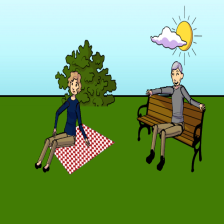

<tf.Tensor: shape=(21,), dtype=int32, numpy=
array([  47,  797, 1903,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)>

<tf.Tensor: shape=(58,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [120]:
from google.colab.patches import cv2_imshow

for (image, question), answer in train_dataset:
  print(image.shape)
  cv2_imshow(np.array(image[0]))
  question[0]
  answer[0]    
  break

# Training

In [121]:
# -----------------
# Set the callbacks
# -----------------
def set_callbacks(type = 'transfer_learning', model_checkpoint = True, visualize_tensorboard = False, early_stop = True, reduce_lr_on_plateau = True):
  
  import os
  from datetime import datetime

  cwd = os.getcwd()

  exps_dir = os.path.join('/content/drive/My Drive/Challenge_3/', 'classification_experiments')
  if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

  model_name = type

  exp_dir = os.path.join(exps_dir, model_name)
  if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
  callbacks = []

  # Model checkpoint
  # ----------------
  if model_checkpoint:
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                       save_weights_only=True,
                                                       save_best_only=True)  # False to save the model directly
    callbacks.append(ckpt_callback)
  # ----------------

  # Visualize Learning on Tensorboard
  # ---------------------------------
  if visualize_tensorboard:
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
    
    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)  # if 1 shows weights histograms
    callbacks.append(tb_callback)
  # ---------------------------------

  # Early Stopping
  # --------------
  if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience = 2,
                                                   restore_best_weights=True)
    callbacks.append(es_callback)
  # --------------

  # Reduce Learning rate on plateau
  # -------------------------------
  if reduce_lr_on_plateau:
    rlr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.5, 
                                                        patience=1, 
                                                        verbose=1, 
                                                        mode='auto', 
                                                        min_delta=0.0001)
    callbacks.append(rlr_callback)
  # -------------------------------

  return callbacks

In [122]:
CNN_Input = tf.keras.layers.Input(shape=(224,224,3), name='image_input')

mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet', input_tensor=CNN_Input)

efficient = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet', input_tensor=CNN_Input)

CNN_model=tf.keras.models.Sequential()
CNN_model.add(CNN_Input)

#CNN_model.add(mobilenetv2)

CNN_model.add(efficient)

CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())


#Creating the RNN model for text processing
RNN_model = tf.keras.models.Sequential()

RNN_Input = tf.keras.layers.Input(shape = (max_length), name='text_input')
RNN_model.add(RNN_Input)
RNN_model.add(tf.keras.layers.Embedding(input_dim = words_number, output_dim = 2048, input_length = max_length, mask_zero=True))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=True, recurrent_initializer='glorot_uniform')))
#RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, stateful=False, return_sequences=True, recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=False, recurrent_initializer='glorot_uniform')))

concat = tf.keras.layers.concatenate([CNN_model.output, RNN_model.output])

dense_out = tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='output')(concat)

model = tf.keras.Model(inputs=[CNN_Input, RNN_Input],
                       outputs = dense_out)
'''
exps_dir = os.path.join('/content/drive/My Drive/Challenge_3/', 'classification_experiments')
model_name = 'effB0'
exp_dir = os.path.join(exps_dir, model_name)
ckpt_dir = os.path.join(exp_dir, 'ckpts')
latest = tf.train.latest_checkpoint(ckpt_dir)
print(latest)
model.load_weights(latest)
'''
model.compile(
  tf.keras.optimizers.Adam(lr=5e-5), # somewhat arbitrarily chosen
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

model.summary()

callbacks = set_callbacks(type='effB0_EMB=2048_LSTM=2x512')

"\nexps_dir = os.path.join('/content/drive/My Drive/Challenge_3/', 'classification_experiments')\nmodel_name = 'effB0'\nexp_dir = os.path.join(exps_dir, model_name)\nckpt_dir = os.path.join(exp_dir, 'ckpts')\nlatest = tf.train.latest_checkpoint(ckpt_dir)\nprint(latest)\nmodel.load_weights(latest)\n"

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 21)]         0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 21, 2048)     9504768     text_input[0][0]                 
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 7, 7, 1280)   4049571     image_input[0][0]                
____________________________________________________________________________________________

In [ ]:
model.fit(train_dataset,
          validation_data = valid_dataset,
          steps_per_epoch = len(train_gen)//BATCH_SIZE,
          epochs = 15,
          callbacks = callbacks)

Epoch 1/15
  77/2117 [>.............................] - ETA: 13:21 - loss: 3.7417 - accuracy: 0.1485

# Results (csv)

In [ ]:
# Create folder for prediction files (csv)
! mkdir '/content/drive/My Drive/Challenge_3/result_csv'

# ------------------------------------
# Create the csv file with predictions
# ------------------------------------
def create_csv(results, results_dir='/content/drive/My Drive/Challenge_3/result_csv'):
  import os
  from datetime import datetime

  csv_fname = 'results_'
  csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

  with open(os.path.join(results_dir, csv_fname), 'w') as f:
    f.write('Id,Category\n')
    for key, value in results.items():
      f.write(key + ',' + str(value) + '\n')

In [ ]:
! ls '/content/drive/My Drive/Challenge_3/result_csv'

In [ ]:
# --------------------------------
# Create the class for the dataset
# --------------------------------

from PIL import Image

class TestDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, tokenizer, img_generator=None, preprocessing_function=None, img_shape=[400, 700]):
    import json
    
    with open(test_json_path, 'r') as f:
      data = json.load(f)

    # Tokenizer fuori perche deve creare variabili globali come word_number ecc.

    self.data = {}
    for i, j in enumerate(data):
      self.data[i] = data[j]
      self.data[i]['question_id'] = j

    self.tokenizer = tokenizer
    
    self.img_generator = img_generator
    
    self.preprocessing_function = preprocessing_function
    
    self.img_shape = img_shape

    self.SEED = 1234

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):

    curr_element = self.data[index]

    # Image
    # -----

    question_id = curr_element['question_id'] #################################################################################
    
    # Read Image
    img = cv2.imread(images_path + curr_element['image_id'] + '.png', cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB ) 
    # Resize image
    img = cv2.resize(img, (self.img_shape[0], self.img_shape[1]), interpolation = cv2.INTER_AREA)
    
    if self.img_generator is not None:
      # Perform data augmentation
      # We can get a random transformation from the ImageDataGenerator using get_random_transform
      # and we can apply it to the image using apply_transform

      #self.SEED = self.SEED + 1
      img_t = self.img_generator.get_random_transform(img_arr.shape, seed=self.SEED)
      img_arr = self.img_generator.apply_transform(img_arr, img_t)
    
    if self.preprocessing_function is not None:
      img_arr = self.preprocessing_function(img_arr)

    # -----

    # Question
    # --------

    question = [curr_element['question']]#.split(' ')
    question[0]= question[0].replace('?', '')
    #print(question)
    question = self.tokenizer.texts_to_sequences(question)
    #print(question)
    question = pad_sequences(question, padding = 'post', maxlen = max_length)
    question = question[0]
    # --------

    return question_id, (np.float32(img), np.int32(question))

In [ ]:
# ------------------------------------------------------------------
# Create train and validation dataset objects using the custom class
# ------------------------------------------------------------------
def create_test_dataset(img_data_gen, img_h, img_w):

  # Training
  # --------
  test_gen = TestDataset(tokenizer = tokenizer,
                        img_generator = None, 
                        img_shape = [img_h, img_w], # size – The requested size in pixels, as a 2-tuple: (h, w). !! np function
                        preprocessing_function = None
                        )

  test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                                 output_types = (tf.string, (tf.float32, tf.int32)),
                                                 output_shapes = (None, ([img_h, img_w, 3], [max_length])))
                                                                                            
  test_dataset = test_dataset.batch(1)
  # --------
  
  return test_dataset, test_gen

In [ ]:
test_dataset, test_gen = create_test_dataset(img_data_gen = None, img_h = 224, img_w = 224)

In [ ]:
for i, (j,k) in test_dataset:
  id  = np.array_str(i.numpy())[3:-2]
  id
  break

In [ ]:
# --------------------------------------
# Make predictions and save the csv file
# --------------------------------------
from PIL import Image

results = {}
counter = 0

for question_id, input in test_dataset:

  counter += 1
  
  question_id = np.array_str(question_id.numpy())[3:-2]

  out_softmax = model.predict(x=input)

  prediction = tf.math.argmax(out_softmax, 1)

  results[question_id] = prediction[0].numpy() # Get first of the batch (but bs = 1)

  print(question_id + ' ---> ' + str(results[question_id]))
  print('------------------------------------------------> ' + str(counter) + ' / ' + str(len(test_gen)))

create_csv(results)

! ls '/content/drive/My Drive/Challenge_3/result_csv'